Интернет-магазин запускает новый сервис, в котором пользователи могут редактировать и дополнять описания товаров(клиенты предлагают свои правки и комментируют изменения других). Нужен инструмент, который будет искать негативные/токсичные комментарии и отправлять их на модерацию. 

Необходимо построить модель (со значением метрики качества F1 не меньше 0.75), которая будет классифицировать комментарии на позитивные и негативные. 

Предоставлен набор комментариев с разметкой о токсичности.


### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — целевой признак.


### План по выполнению проекта:  
1. Загрузим данные и выполним и проведём анализ целевого признака.  
2. Проанализируем данные.  
3. Обработаем текст.
4. Трансформируем текстовое содержимое в числовые вектора признаков.
5. Разделим выборку на обучающую и тестовую (80:20).
6. Обучим разные модели. Проанализируем значения метрики F1 и выберем лучшие.
7. Проверим данные на кросс-валидации тестовой выборки.

In [2]:
import numpy as np
import pandas as pd

# !pip install textblob      #for installation
import textblob            #to import
from textblob import TextBlob

import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.metrics import make_scorer

import time

from sklearn.model_selection import KFold, cross_val_predict

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Toomas
[nltk_data]     A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('datasets/toxic_comments.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


# 1. Подготовка

Для начала проанализируем все комментарии на предмет качества (`toxic`).  

0    143346
1     16225
Name: toxic, dtype: int64


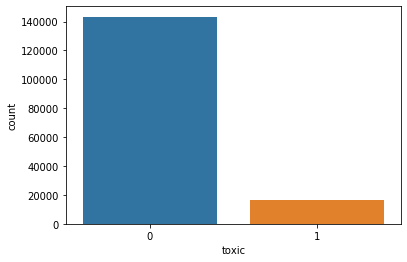

In [4]:
print(data.toxic.value_counts())
sns.countplot(x= 'toxic',data = data)

Как видим, позитивных комментариев почти в 9 раз больше, чем негативных. Важно, что данные в нашей выборке несбаллансированы, количество нулевого целевого признака в разы больше единичного.  


Используя модули `TextBlob` и `WordNetLemmatizer`, плюс пакет `stopwords` к библиотеке NLTK, модуль `re`, напишем функцию для предобработки текста (токенизации, отфильтровывания стоп-слов и лемматизации).  

Так как предоставленный датасет достаточно большой, на предобработку и обучение потребуется много времени. Для ускорения процесса воспользуемся частью предоставленных данных.

In [5]:
dat = data.sample(110000, random_state=1).reset_index(drop=True)
dat
print(dat.toxic.value_counts())

0    98789
1    11211
Name: toxic, dtype: int64


In [6]:
def preprocessing(tweet):
    tweet_punct = ' '.join(TextBlob(tweet).words) # убираем знаки препинания
    tweet_list = [ele for ele in tweet_punct.split()] # преобразование текста в набор слов
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)] # проверка, подходит ли слово под шаблон
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')] # убираем стоп-слова,
                                                    #   которые не несут смысловой нагрузки (артикли, междометия, союзы и т.д.)
    lower_case = list(map(lambda x:x.lower(), clean_mess)) # перевод заглавных в строчные буквы
    
    lem = WordNetLemmatizer() # лемматизация
    normalized_tweet = []
    for word in lower_case:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    clean = ' '.join(normalized_tweet) #  соединие слов из списка в строку   
    return clean

In [7]:
dat.text = dat.text.apply(preprocessing) # предобработка текста
dat

,text,toxic
0,fat geeky prick nothing weekend monitor wikipe...,1
1,agent basically thank little bite case lie nat...,0
2,post delete try make discussion user deepak ke...,0
3,control demolitions common sense recommend rea...,0
4,understand reply blaxthos c,0
...,...,...
109995,btw warn far exact opposite intend apparently ...,0
109996,pretty retard response something stupid like c...,1
109997,hi question story start fifth paragraph find s...,0
109998,someone toy boy alias allude right physics cre...,0


После очистки разделим датасет на обучающую и тестовую выборки, а затем трансформируем текстовое содержимое в числовые вектора признаков с помощью TfidfVectorizer.  

Разделим предобработанный датасет на обучающую и тестовую выборки. Так как изначально наш целевой признак (`toxic`) несбалансирован, применим параметр `stratify`, который позволит сделать разделение так, что доля значений в произведенном образце будет такой же, как доля предоставленных значений.   

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dat.text, dat.toxic, test_size=0.3, random_state=1234, stratify=dat.toxic)

print('Обучающая выборка:', X_train.shape)
print('Целевой признак обучающей выборки:', y_train.shape, '\n')

print('Тестовая выборка:',X_test.shape)
print('Целевой признак тестовой выборки:', y_test.shape, '\n')

Обучающая выборка: (77000,)
Целевой признак обучающей выборки: (77000,) 

Тестовая выборка: (33000,)
Целевой признак тестовой выборки: (33000,) 



In [9]:
tfidfconverter = TfidfVectorizer(max_features=3500, max_df=0.7, min_df=20, binary=False)
X_train_tf = tfidfconverter.fit_transform(X_train).toarray() # обучаем тренировочную выборку
X_test = tfidfconverter.transform(X_test) # векторизуем тестовую выборку

In [10]:
X_train_tf.shape

(77000, 3500)

# 2. Обучение  

Для анализа качества предсказаний выберем несколько классификаторов. Начнем с Наивного Байесовского классификатора (полиноминальный вариант - [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)), который станет отправной точкой для нашей задачи. Далее, используя перекрестную валидацию, оценим как на обучающей выборке покажут себя LogisticRegression, метод опорных векторов - LinearSVC, бустинг модели - AdaBoostClassifier и XGBClassifier, и, наконец, посмотрим, как покажет себя RandomForestClassifier.  
Причем, для оценки работы модели будем учитывать не только целевую метрику F1, но и время затраченное на обучение и предсказание обучающей выборки.  

Напишем функцию для расчёта среднего (невзвешенного) значения F1.

In [11]:
def f1(y, pred):
    return f1_score(y, pred)

In [12]:
from sklearn.model_selection import cross_val_score
print('- F1 score - \n')                             

pipelines = []
pipelines.append(('MNB', MultinomialNB()))
pipelines.append(('LR', LogisticRegression()))
pipelines.append(('LSVC', LinearSVC(random_state=1234)))
pipelines.append(('AdaBoost', AdaBoostClassifier(random_state=1234)))
pipelines.append(('XGBoost', XGBClassifier()))
pipelines.append(('RFC', RandomForestClassifier(random_state=1234, n_jobs=-1)))

for name, model in pipelines:
    start_time = time.time()
    
    kf = KFold(n_splits=5,random_state=1234, shuffle=True)
    f1_cv = cross_val_score(model, X_train_tf, y_train, cv=kf, scoring='f1')
    
    end_time = time.time()
    duration = end_time - start_time
    
    msg = "%s: %f (ET: %.2fs)" % (name, f1_cv.mean(), duration)
    print(msg)

- F1 score - 

MNB: 0.649471 (ET: 11.75s)
LR: 0.716690 (ET: 123.78s)
LSVC: 0.756486 (ET: 15.56s)
AdaBoost: 0.679897 (ET: 2013.94s)
XGBoost: 0.713504 (ET: 2682.89s)
RFC: 0.736363 (ET: 3312.80s)


Первое, на что следует обратить внимание, – это время (соответственно, необходимые вычислительные ресурсы). Первые три классификатора справились с задачей достаточно быстро (до 2 мин.), бустинг-модели ту же задачу выполнили намного дольше.  

*Хотя результат метрики F1 у случайного леса получился неплохой (~0.74), но процесс занял почти час!*    

Целевая метрика F1 ближе всего к единице у LinearSVC, LogisticRegression.

Остановимся на моделях, показавших лучшие результаты и попробуем улучшить качество, оптимизируя гиперпараметры. А затем проанализируем качество на тестовой выборке.  

Для оценки, помимо целевой метрики, будем использовать матрицу ошибок, которая наглядно позволит оценить эффективность прогноза не только в качественном, но и в количественном выражении.

---


#### Настройка гиперпараметров и проверка результатов на тестовой выборке


In [13]:
def pred_vis(y_test, y_pred):                              # матрица ошибок
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
 
    labels = ['Toxic 0', 'Toxic 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 529.9min finished


F1 TEST модели LR: 0.7611866907064415

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     29637
           1       0.85      0.69      0.76      3363

    accuracy                           0.96     33000
   macro avg       0.91      0.84      0.87     33000
weighted avg       0.95      0.96      0.95     33000

Confusion matrix:
 [[29221   416]
 [ 1041  2322]]


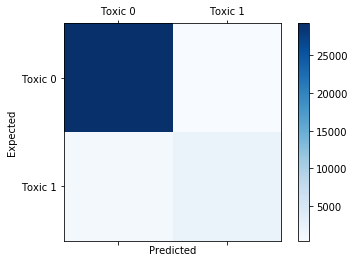

In [14]:
my_scorer = make_scorer(f1, greater_is_better=True) # зададим параметр целевой метрики качества (чем больше, тем лучше)
cv = KFold(n_splits=5,random_state=42, shuffle=False)

lr = LogisticRegression(random_state=42, n_jobs=-1)

param_dist = {"max_iter": sp_randint(100, 1000),
              "penalty": ['l1', 'l2'],
              "C": sp_randint(10, 75)}
      
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist,
                                   n_iter=5, cv=cv, scoring=my_scorer, random_state=42, verbose=True)

random_search_lr.fit(X_train_tf, y_train)
random_search_lr.best_params_

y_preds = random_search_lr.predict(X_test)

f1_lr = f1(y_test, y_preds)

print('F1 TEST модели LR:', f1_lr)
print('\n', classification_report(y_test, y_preds))

pred_vis(y_test, y_preds)

На тестовой выборке на матрице ошибок наглядно видно верные предсказания. Из 33000, 31543 предсказаны верно.

In [15]:
lsvc = LinearSVC(random_state=42)

param_dist = {"max_iter": sp_randint(100, 1000),
              "loss": ['hinge', 'squared_hinge'],
              "C": np.linspace(0.001, 1, 10)}
        
random_search_lsvc = RandomizedSearchCV(lsvc, param_distributions=param_dist, n_iter=5,
                                        cv=cv, scoring=my_scorer, random_state=42, verbose=1)

random_search_lsvc.fit(X_train_tf, y_train)

random_search_lsvc.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.3min finished


{'C': 0.667, 'loss': 'squared_hinge', 'max_iter': 960}

F1 TEST модели LSVC: 0.7581765802406373

               precision    recall  f1-score   support

           0       0.96      0.99      0.98     29637
           1       0.88      0.67      0.76      3363

    accuracy                           0.96     33000
   macro avg       0.92      0.83      0.87     33000
weighted avg       0.95      0.96      0.95     33000

Confusion matrix:
 [[29336   301]
 [ 1126  2237]]


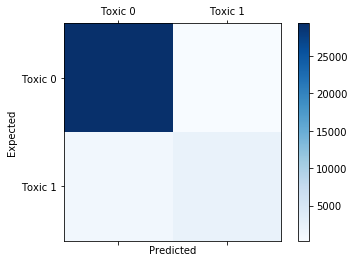

In [16]:
y_pred_lsvc = random_search_lsvc.predict(X_test) # тестовая выборка

f1_lsvc = f1(y_test, y_pred_lsvc)

print('F1 TEST модели LSVC:', f1_lsvc)
print('\n', classification_report(y_test, y_pred_lsvc))
pred_vis(y_test, y_pred_lsvc)

Классификатор опорных векторов LinearSVC из 33000 не ошибся в 31573 случаях.

# 3. Выводы

Обе модели (LinearSVC, LogisticRegression) показали хорошие результаты на тестовой выборке (F1>0.75). Бустинг модели - AdaBoostClassifier и XGBClassifier справились с задачей хуже, плюс, время потраченное на обучение и предсказание значительно превосходит первые 2 модели. Качественная метрика классификатора RandomForestClassifier ненамного отстает от лидеров, но катастрофически проигрывает по скорости. 